<a href="https://colab.research.google.com/github/alankriti-dubey/DIC-Project/blob/main/DIC_Phase_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Required Libraries

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, expr, count, when, lit, initcap
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Creating Spark Session

In [ ]:

# Stop any active Spark session
active_session = SparkSession.getActiveSession()
if active_session is not None:
    active_session.stop()

# Create a new Spark session
spark = SparkSession.builder.appName("DiabetesPrediction").getOrCreate()


## Reading dataset

In [ ]:
# Read data from CSV file into a DataFrame
df = spark.read.csv("diabetes_prediction_dataset.csv", header=True, inferSchema=True)

# Show the content of the DataFrame
df.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart_disease|smoking_history|  bmi|HbA1c_level|blood_glucose_level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

## Data Preprocessing


### 1. Dropping Duplicate Rows

In [ ]:
# Drop duplicate rows
df = df.dropDuplicates()

# Show the count of records after dropping duplicates
print(f"Number of records after dropping duplicates: {df.count()}")

Number of records after dropping duplicates: 96146


### 2. Converting Categorical Labels into a Numerical Format

In [ ]:

# Convert categorical labels (e.g., 'gender') to numerical format
indexer = StringIndexer(inputCol="gender", outputCol="gender_indexed")
df = indexer.fit(df).transform(df)


indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_indexed")
df = indexer.fit(df).transform(df)

# Show the transformed DataFrame
print(df.select("smoking_indexed").distinct().collect())
df.select("gender_indexed").distinct().collect()


[Row(smoking_indexed=0.0), Row(smoking_indexed=1.0), Row(smoking_indexed=4.0), Row(smoking_indexed=3.0), Row(smoking_indexed=2.0), Row(smoking_indexed=5.0)]


[Row(gender_indexed=0.0), Row(gender_indexed=1.0), Row(gender_indexed=2.0)]

### 3. Handling Outliers for the 'age' Column

In [ ]:

# Ensure 'age' contains only integer values
df = df.filter(col("age").cast("int").isNotNull())

# Show the count of records after filtering
print(f"Number of records after handling age outliers: {df.count()}")


Number of records after handling age outliers: 96146


### 4. Handling Outliers for the 'BMI' Column Using IQR

In [ ]:

# Calculate Q1 and Q3
Q1 = df.approxQuantile("bmi", [0.25], 0.01)[0]
Q3 = df.approxQuantile("bmi", [0.75], 0.01)[0]
IQR = Q3 - Q1

# Calculate outlier boundaries
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Filter rows that are within the acceptable range
df = df.filter((col("bmi") >= lower_limit) & (col("bmi") <= upper_limit))

# Show the filtered DataFrame
df.select("bmi").show(5)

+-----+
|  bmi|
+-----+
|27.32|
|27.32|
| 21.7|
|20.47|
| 31.4|
+-----+
only showing top 5 rows



### 5. Filtering Rows with Invalid Biological Values

In [ ]:
df = df.filter((col("age") > 1) & (col("bmi") > 10) & (col("blood_glucose_level") >= 80))

# Show the filtered DataFrame
df.select("age", "bmi", "blood_glucose_level").show(5)

+----+-----+-------------------+
| age|  bmi|blood_glucose_level|
+----+-----+-------------------+
|21.0|27.32|                126|
|26.0|27.32|                100|
|49.0| 21.7|                158|
|24.0|20.47|                100|
|53.0| 31.4|                 85|
+----+-----+-------------------+
only showing top 5 rows



### 6. Checking for Inconsistent Data in Categorical Column

In [ ]:

df = df.withColumn("smoking_history", initcap(col("smoking_history")))

# Show the transformed DataFrame
df.select("smoking_history").show(5)

+---------------+
|smoking_history|
+---------------+
|          Never|
|          Never|
|          Never|
|         Former|
|          Never|
+---------------+
only showing top 5 rows



### 7. Handling missing values

In [ ]:


# Calculate the mode of 'smoking_history'
mode_value = df.groupBy("smoking_history").count().orderBy(col("count").desc()).first()[0]

# Replace 'No info' with the mode value
df = df.withColumn("smoking_history", when(col("smoking_history") == "No info", lit(mode_value)).otherwise(col("smoking_history")))

# Show the modified DataFrame
df.select("smoking_history").show(5)

+---------------+
|smoking_history|
+---------------+
|          Never|
|          Never|
|          Never|
|         Former|
|          Never|
+---------------+
only showing top 5 rows



### 8. Normalizing values

In [ ]:

# Assemble columns into a vector
assembler = VectorAssembler(inputCols=["blood_glucose_level", "HbA1c_level"], outputCol="features")
df = assembler.transform(df)

# Apply StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Show the scaled features
df.select("scaled_features").show(5)

+--------------------+
|     scaled_features|
+--------------------+
|[-0.2904463527940...|
|[-0.9344938505553...|
|[0.50222749060444...|
|[-0.9344938505553...|
|[-1.3060597146483...|
+--------------------+
only showing top 5 rows



### 9. Dropping Null Values

In [ ]:
# Drop rows with null values
df = df.na.drop()

# Show the count of records after dropping nulls
print(f"Number of records after dropping nulls: {df.count()}")

Number of records after dropping nulls: 89595


### 10. Feature Engineering

In [ ]:

# Define BMI categories
df = df.withColumn("bmi_category",
                   when((col("bmi") > 0) & (col("bmi") <= 18.5), "Underweight")
                   .when((col("bmi") > 18.5) & (col("bmi") <= 24.9), "Normal")
                   .when((col("bmi") > 24.9) & (col("bmi") <= 29.9), "Overweight")
                   .when((col("bmi") > 29.9), "Obese"))

# Show the categorized BMI column
df.select("bmi", "bmi_category").show(5)

+-----+------------+
|  bmi|bmi_category|
+-----+------------+
|27.32|  Overweight|
|27.32|  Overweight|
| 21.7|      Normal|
|20.47|      Normal|
| 31.4|       Obese|
+-----+------------+
only showing top 5 rows



In [ ]:
print(df)

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, smoking_history: string, bmi: double, HbA1c_level: double, blood_glucose_level: int, diabetes: int, gender_indexed: double, smoking_indexed: double, features: vector, scaled_features: vector, bmi_category: string]


## Algorithms/Visualizations

### Splitting the Dataset

In [ ]:
# Selecting final dataset
final_data = df.select(col("scaled_features"), col("diabetes").alias("label"))

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=1234)

### 1.Logistic Regression

In [ ]:
# Initializing Logistic Regression model
logistic_reg = LogisticRegression(featuresCol="scaled_features", labelCol="label")

# Training the model
logistic_model = logistic_reg.fit(train_data)

# Evaluating on test data
predictions = logistic_model.transform(test_data)
predictions.select("scaled_features", "label", "prediction").show()


+--------------------+-----+----------+
|     scaled_features|label|prediction|
+--------------------+-----+----------+
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance

#### Accuracy

In [ ]:
# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9578343452347797


#### Confusion Matrix

In [ ]:
# Confusion matrix
conf_matrix = predictions.groupBy("label", "prediction").count()
conf_matrix.show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  636|
|    0|       0.0|16455|
|    1|       1.0|  741|
|    0|       1.0|  121|
+-----+----------+-----+



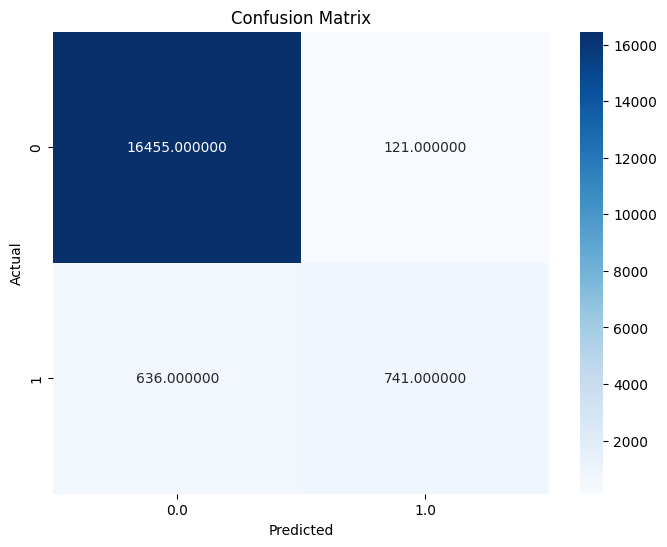

In [ ]:
conf_matrix_pd = conf_matrix.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt="f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


### AUC-ROC

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")


AUC: 0.9279836340191734


### 2. Decision Tree

In [ ]:

# Initializing Decision Tree model
decision_tree = DecisionTreeClassifier(featuresCol="scaled_features", labelCol="label")

# Training the model
dt_model = decision_tree.fit(train_data)

# Evaluating on test data
predictions = dt_model.transform(test_data)
predictions.select("scaled_features", "label", "prediction").show()


+--------------------+-----+----------+
|     scaled_features|label|prediction|
+--------------------+-----+----------+
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance

#### Accuracy

In [ ]:
# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.9749345513284687


### Confusion Matrix

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  450|
|    0|       0.0|16576|
|    1|       1.0|  927|
+-----+----------+-----+



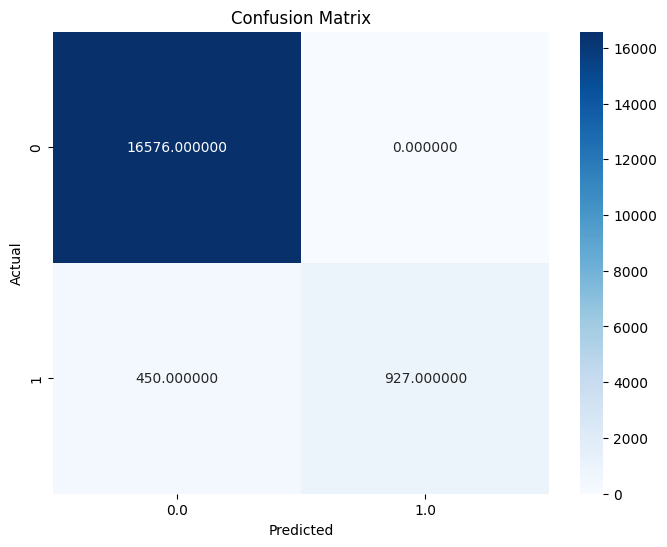

In [ ]:
# Confusion matrix
conf_matrix = predictions.groupBy("label", "prediction").count()
conf_matrix.show()

conf_matrix_pd = conf_matrix.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt="f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


#### AUC-ROC

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.6376180101670298


### 3. Random Forest

In [ ]:

# Initializing Random Forest model
random_forest = RandomForestClassifier(featuresCol="scaled_features", labelCol="label", numTrees=10)

# Training the model
rf_model = random_forest.fit(train_data)

# Evaluating on test data
predictions = rf_model.transform(test_data)
predictions.select("scaled_features", "label", "prediction").show()


+--------------------+-----+----------+
|     scaled_features|label|prediction|
+--------------------+-----+----------+
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
|[-1.4299150026794...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



#### Evaluating Model Performance


#### Accuracy

In [ ]:
# Evaluating accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9749345513284687


Confusion Matrix

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|  450|
|    0|       0.0|16576|
|    1|       1.0|  927|
+-----+----------+-----+



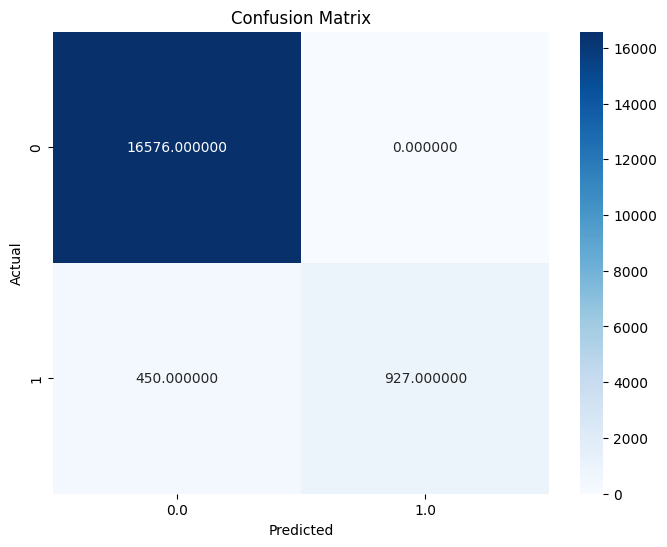

In [ ]:
# Confusion matrix
conf_matrix = predictions.groupBy("label", "prediction").count()
conf_matrix.show()

conf_matrix_pd = conf_matrix.toPandas().pivot(index='label', columns='prediction', values='count').fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt="f", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


AUC-ROC

In [ ]:
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

AUC: 0.8366013071895425


#### Feature Importance

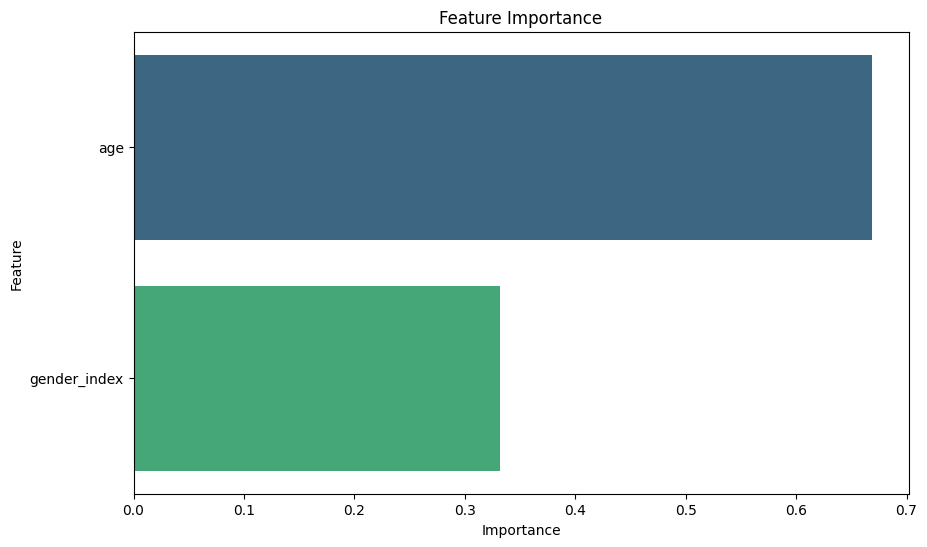

In [ ]:
# Featuring importance for Random Forest
rf_importance = rf_model.featureImportances

# Mapping to feature names
features = ["gender_index", "age", "hypertension", "heart_disease", "smoking_index", "bmi", "HbA1c_level", "blood_glucose_level"]
importances = list(zip(features, rf_importance.toArray()))

# Converting to Pandas for visualization
importance_df = pd.DataFrame(importances, columns=["Feature", "Importance"]).sort_values(by="Importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis", hue='Feature', legend= False)
plt.title("Feature Importance")
plt.show()


SVM

MODEL AND AUC CURVE

In [ ]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

svm = LinearSVC(featuresCol="scaled_features", labelCol="diabetes", predictionCol="prediction", maxIter=10)
svm_model = svm.fit(df)
svm_predictions = svm_model.transform(df)
evaluator = BinaryClassificationEvaluator(labelCol="diabetes", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(svm_predictions)
print(f"AUC: {roc_auc}")
svm_predictions.select("diabetes", "prediction").show()


AUC: 0.9234180566234662
+--------+----------+
|diabetes|prediction|
+--------+----------+
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       0|       0.0|
|       1|       1.0|
|       0|       0.0|
|       0|       0.0|
+--------+----------+
only showing top 20 rows



In [ ]:
!pip install pyngrok
from pyngrok import ngrok

In [ ]:

spark_port = spark.conf.get("spark.ui.port", "4040")
print(f"Spark UI is running on port: {spark_port}")


Spark UI is running on port: 4040


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("auth_token") #Change it using ur credentials
public_url = ngrok.connect(4040)

print(f"Spark Web UI is available at: {public_url}")

Spark Web UI is available at: NgrokTunnel: "https://075b-34-168-99-4.ngrok-free.app" -> "http://localhost:4040"


In [ ]:
!pkill -f ngrok

CONFUSION MATRIX

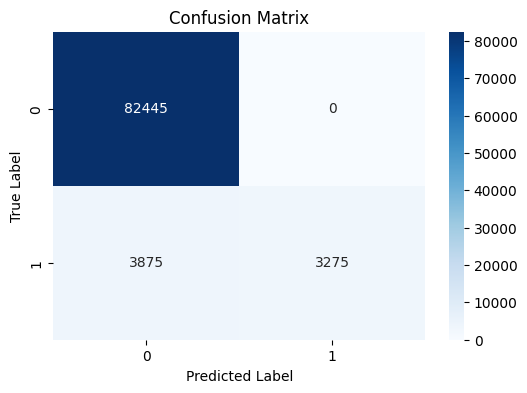

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
confusion_matrix_values = svm_predictions.groupBy("diabetes", "prediction").count()
confusion_matrix_dict = {(row["diabetes"], row["prediction"]): row["count"] for row in confusion_matrix_values.collect()}

labels = [0, 1]

confusion_matrix_array = np.zeros((2, 2))
for i in labels:
    for j in labels:
        confusion_matrix_array[i][j] = confusion_matrix_dict.get((i, j), 0)

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix_array, annot=True, fmt=".0f", cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


ACCURACY AND F1-SCORE

In [ ]:
from pyspark.sql import functions as F
confusion_matrix = svm_predictions.groupBy("diabetes", "prediction").count().orderBy("diabetes", "prediction")
confusion_matrix.show()

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = accuracy_evaluator.evaluate(svm_predictions)
print(f"Accuracy: {accuracy}")

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(svm_predictions)
print(f"F1 Score: {f1_score}")


+--------+----------+-----+
|diabetes|prediction|count|
+--------+----------+-----+
|       0|       0.0|82445|
|       1|       0.0| 3875|
|       1|       1.0| 3275|
+--------+----------+-----+

Accuracy: 0.9567498186282717
F1 Score: 0.9492082473960428


KNN

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors, DenseVector
from pyspark.sql.functions import col, udf, lit, row_number, count
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql import Window
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

query_point = DenseVector([0.5] * len(df.select("scaled_features").first()["scaled_features"]))

def euclidean_distance(v1, query_point):
    diff = v1.toArray() - query_point.toArray()
    return float((diff @ diff) ** 0.5)

distance_udf = udf(lambda v: euclidean_distance(v, query_point), FloatType())

df_with_distances = df.withColumn(
    "distance",
    distance_udf(col("scaled_features"))
)

k = 3
window = Window.orderBy("distance")
knn_results = df_with_distances.withColumn("rank", row_number().over(window)).filter(col("rank") <= k)
knn_prediction = (
    knn_results.groupBy("diabetes")
    .count()
    .orderBy(col("count").desc())
    .first()["diabetes"]
)

df_with_prediction = df_with_distances.withColumn("prediction", lit(knn_prediction))
df_with_prediction = df_with_prediction.withColumn("prediction", col("prediction").cast(DoubleType()))
df_with_prediction = df_with_prediction.withColumn("diabetes", col("diabetes").cast(DoubleType()))

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = accuracy_evaluator.evaluate(df_with_prediction)
print(f"Accuracy: {accuracy}")

# Precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(df_with_prediction)
print(f"Precision: {precision}")

# Recall
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(df_with_prediction)
print(f"Recall: {recall}")

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="diabetes",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(df_with_prediction)
print(f"F1 Score: {f1_score}")


Accuracy: 0.9201964395334561
Precision: 0.8467614873300495
Recall: 0.9201964395334561
F1 Score: 0.8819529813687025


In [ ]:
!pip install pyngrok
from pyngrok import ngrok

In [ ]:
spark_port = spark.conf.get("spark.ui.port", "4040")
print(f"Spark UI is running on port: {spark_port}")


Spark UI is running on port: 4040


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("auth_token") #Change it using ur credentials
public_url = ngrok.connect(4040)

print(f"Spark Web UI is available at: {public_url}")

Spark Web UI is available at: NgrokTunnel: "https://075b-34-168-99-4.ngrok-free.app" -> "http://localhost:4040"


In [ ]:
!pkill -f ngrok

EVALUATION METRICS

In [ ]:
metrics_df = df_with_prediction.withColumn(
    "tp", when((col("diabetes") == 1) & (col("prediction") == 1), 1).otherwise(0)
).withColumn(
    "fp", when((col("diabetes") == 0) & (col("prediction") == 1), 1).otherwise(0)
).withColumn(
    "fn", when((col("diabetes") == 1) & (col("prediction") == 0), 1).otherwise(0)
).withColumn(
    "tn", when((col("diabetes") == 0) & (col("prediction") == 0), 1).otherwise(0)
)

# Aggregate metrics for each class
class_metrics = metrics_df.groupBy("diabetes").agg(
    count("tp").alias("tp"),
    count("fp").alias("fp"),
    count("fn").alias("fn"),
    count("tn").alias("tn")
)

# Calculate precision and recall for each class
class_metrics = class_metrics.withColumn(
    "precision", col("tp") / (col("tp") + col("fp"))
).withColumn(
    "recall", col("tp") / (col("tp") + col("fn"))
)

# Show class-wise precision and recall
class_metrics.select("diabetes", "precision", "recall").show()


+--------+---------+------+
|diabetes|precision|recall|
+--------+---------+------+
|     0.0|      0.5|   0.5|
|     1.0|      0.5|   0.5|
+--------+---------+------+



AUC

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(df_with_prediction)
print(f"AUC: {auc}")


AUC: 0.5


NAIVE BAYES

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("NaiveBayes").getOrCreate()

from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml import Pipeline

gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
smoking_history_indexer = StringIndexer(inputCol="smoking_history", outputCol="smoking_history_index")
bmi_category_indexer = StringIndexer(inputCol="bmi_category", outputCol="bmi_category_index")
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_vector")
smoking_history_encoder = OneHotEncoder(inputCol="smoking_history_index", outputCol="smoking_history_vector")
bmi_category_encoder = OneHotEncoder(inputCol="bmi_category_index", outputCol="bmi_category_vector")

assembler = VectorAssembler(
    inputCols=["age", "hypertension", "heart_disease", "bmi", "HbA1c_level",
               "blood_glucose_level", "gender_vector", "smoking_history_vector", "bmi_category_vector"],
    outputCol="assembled_features"
)


pipeline = Pipeline(stages=[
    gender_indexer, smoking_history_indexer, bmi_category_indexer,
    gender_encoder, smoking_history_encoder, bmi_category_encoder,
    assembler
])

processed_data = pipeline.fit(df).transform(df)

data = processed_data.select("assembled_features", "diabetes").withColumnRenamed("assembled_features", "features").withColumnRenamed("diabetes", "label")

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

nb = NaiveBayes(labelCol="label", featuresCol="features", modelType="multinomial")
model = nb.fit(train_data)
predictions = model.transform(test_data)

In [ ]:
!pip install pyngrok
from pyngrok import ngrok

In [ ]:
# Check Spark Web UI port
spark_port = spark.conf.get("spark.ui.port", "4040")
print(f"Spark UI is running on port: {spark_port}")


Spark UI is running on port: 4040


In [ ]:
from pyngrok import ngrok

ngrok.set_auth_token("AUTH_TOKEN")
public_url = ngrok.connect(4040)

print(f"Spark Web UI is available at: {public_url}")

Spark Web UI is available at: NgrokTunnel: "https://ad58-34-16-145-224.ngrok-free.app" -> "http://localhost:4040"


Accuracy: 0.9177144140098787
F1 Score: 0.9141169998009271


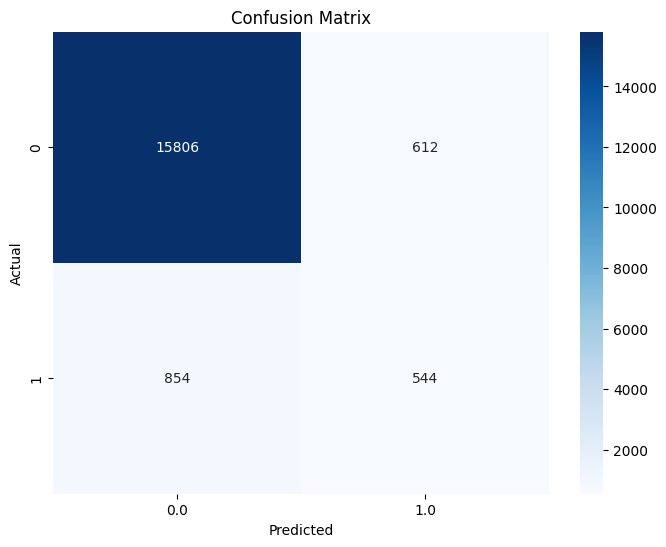

In [ ]:

accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(predictions)
print(f"F1 Score: {f1_score}")

conf_matrix = predictions.groupBy("label", "prediction").count()

conf_matrix_pd = conf_matrix.toPandas().pivot(index="label", columns="prediction", values="count").fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_pd, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
